<a href="https://colab.research.google.com/github/Rak18936/Rakshaya/blob/main/Android_App_Market_ANALYSIS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

 **Import Libraries**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from textblob import TextBlob
import warnings
warnings.filterwarnings('ignore')



**Load the Data**

In [ ]:
from google.colab import files

uploaded = files.upload()

Saving archive (1).zip to archive (1).zip


In [ ]:
import zipfile
import os


zip_file_path = 'archive (1).zip'
extract_path = '.'

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)


print("Files extracted:")
print(os.listdir(extract_path))

Files extracted:
['.config', 'archive (1).zip', 'datasets', 'sample_data']


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9659 entries, 0 to 9658
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Unnamed: 0      9659 non-null   int64  
 1   App             9659 non-null   object 
 2   Category        9659 non-null   object 
 3   Rating          8196 non-null   float64
 4   Reviews         9659 non-null   int64  
 5   Size            8432 non-null   float64
 6   Installs        9659 non-null   object 
 7   Type            9659 non-null   object 
 8   Price           9659 non-null   object 
 9   Content Rating  9659 non-null   object 
 10  Genres          9659 non-null   object 
 11  Last Updated    9659 non-null   object 
 12  Current Ver     9651 non-null   object 
 13  Android Ver     9657 non-null   object 
dtypes: float64(2), int64(2), object(10)
memory usage: 1.0+ MB


In [ ]:
df=pd.read_csv('datasets/apps.csv')
df.head()

,Unnamed: 0,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
0,0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19.0,"10,000+",Free,0,Everyone,Art & Design,"January 7, 2018",1.0.0,4.0.3 and up
1,1,Coloring book moana,ART_AND_DESIGN,3.9,967,14.0,"500,000+",Free,0,Everyone,Art & Design;Pretend Play,"January 15, 2018",2.0.0,4.0.3 and up
2,2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.7,87510,8.7,"5,000,000+",Free,0,Everyone,Art & Design,"August 1, 2018",1.2.4,4.0.3 and up
3,3,Sketch - Draw & Paint,ART_AND_DESIGN,4.5,215644,25.0,"50,000,000+",Free,0,Teen,Art & Design,"June 8, 2018",Varies with device,4.2 and up
4,4,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,4.3,967,2.8,"100,000+",Free,0,Everyone,Art & Design;Creativity,"June 20, 2018",1.1,4.4 and up


In [ ]:

apps = pd.read_csv('/content/datasets/apps.csv')
reviews = pd.read_csv('/content/datasets/user_reviews.csv')

# Quick preview
apps.head()
reviews.head()


,App,Translated_Review,Sentiment,Sentiment_Polarity,Sentiment_Subjectivity
0,10 Best Foods for You,I like eat delicious food. That's I'm cooking ...,Positive,1.00,0.533333
1,10 Best Foods for You,This help eating healthy exercise regular basis,Positive,0.25,0.288462
2,10 Best Foods for You,NaN,NaN,NaN,NaN
3,10 Best Foods for You,Works great especially going grocery store,Positive,0.40,0.875000
4,10 Best Foods for You,Best idea us,Positive,1.00,0.300000


***Data Cleaning & Preparation***

In [ ]:
# Remove duplicates
apps.drop_duplicates(inplace=True)

# Handle missing values
apps.dropna(subset=['App', 'Category', 'Rating'], inplace=True)

# Convert Reviews and Installs to numeric
apps['Reviews'] = pd.to_numeric(apps['Reviews'], errors='coerce')
apps['Installs'] = apps['Installs'].astype(str).str.replace(r'[+,]', '', regex=True).astype(float)
apps['Price'] = apps['Price'].astype(str).str.replace('$', '').astype(float)

# Convert Size to MB
def convert_size(size):
    if size.endswith('M'):
        return float(size[:-1])
    elif size.endswith('k'):
        return float(size[:-1]) / 1024
    elif size == 'Varies with device':
        return np.nan
    else:
        return np.nan

apps['Size'] = apps['Size'].astype(str).apply(convert_size)
apps['Size'].fillna(apps['Size'].mean(), inplace=True)

**Category Exploration**

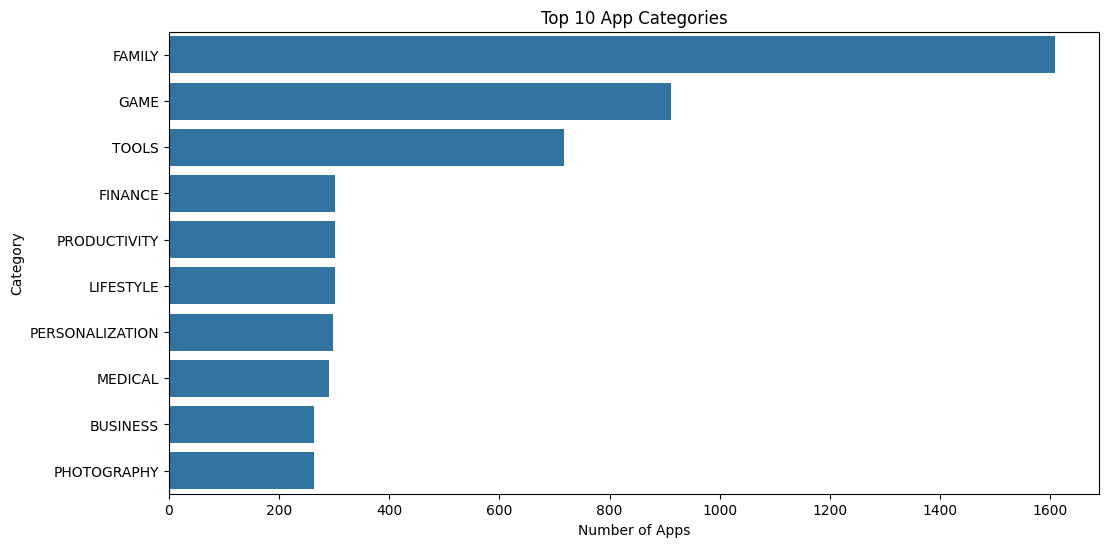

In [ ]:
# Number of apps per category
category_count = apps['Category'].value_counts()

# Bar plot
plt.figure(figsize=(12,6))
sns.barplot(y=category_count.index[:10], x=category_count.values[:10])
plt.title("Top 10 App Categories")
plt.xlabel("Number of Apps")
plt.ylabel("Category")
plt.show()


**Metrics Analysis**

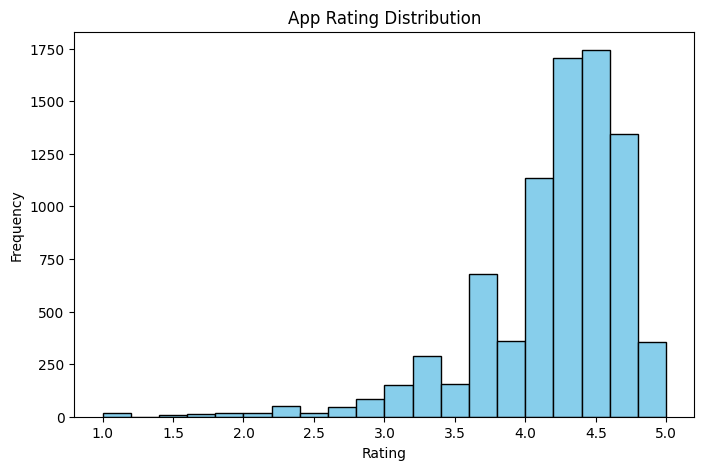

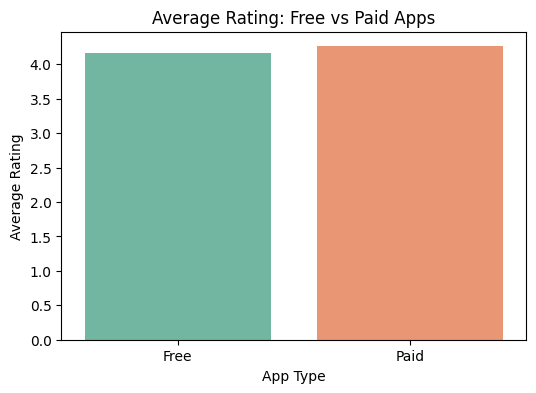

In [ ]:
# SAMPLE the data for faster rendering (scatterplots especially)
apps_sample = apps.sample(n=1000, random_state=42)

# Faster Histogram (Rating Distribution without KDE)
plt.figure(figsize=(8,5))
plt.hist(apps['Rating'].dropna(), bins=20, color='skyblue', edgecolor='black')
plt.title("App Rating Distribution")
plt.xlabel("Rating")
plt.ylabel("Frequency")
plt.show()


#  Paid vs Free (Use mean ratings instead of raw boxplot)
type_rating = apps.groupby('Type')['Rating'].mean().reset_index()

plt.figure(figsize=(6,4))
sns.barplot(data=type_rating, x='Type', y='Rating', palette='Set2')
plt.title("Average Rating: Free vs Paid Apps")
plt.ylabel("Average Rating")
plt.xlabel("App Type")
plt.show()


**Sentiment Analysis (User Reviews)**

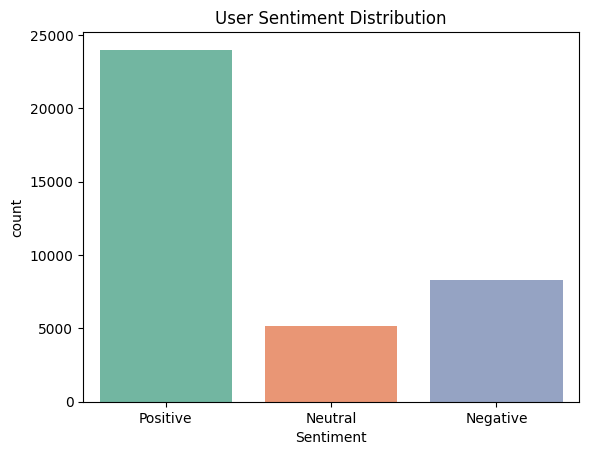

In [ ]:
# Drop NA in reviews
reviews.dropna(subset=['Translated_Review'], inplace=True)

# Polarity Score using TextBlob
reviews['Polarity'] = reviews['Translated_Review'].apply(lambda x: TextBlob(x).sentiment.polarity)

# Classify sentiment
def get_sentiment(score):
    if score > 0:
        return 'Positive'
    elif score < 0:
        return 'Negative'
    else:
        return 'Neutral'

reviews['Sentiment'] = reviews['Polarity'].apply(get_sentiment)

# Count plot
sns.countplot(data=reviews, x='Sentiment', palette='Set2')
plt.title("User Sentiment Distribution")
plt.show()


reviews**WordCloud for Positive **

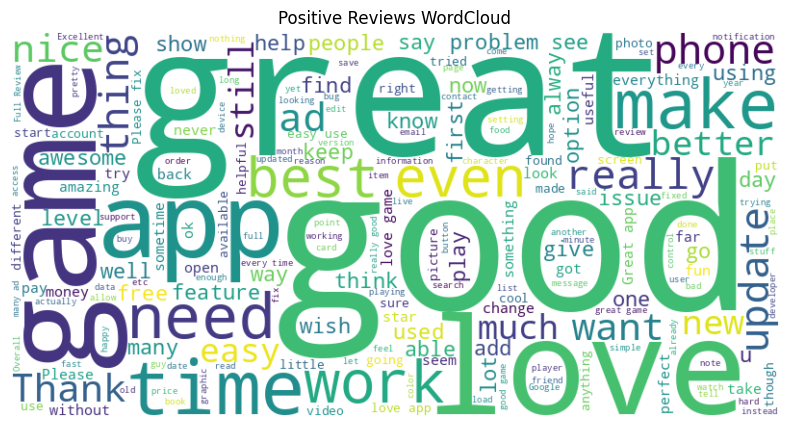

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Positive wordcloud
plt.figure(figsize=(10, 5))
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(positive_reviews)
plt.imshow(wordcloud, interpolation='bilinear')  # <--- You missed this line!
plt.title("Positive Reviews WordCloud")
plt.axis('off')
plt.show()